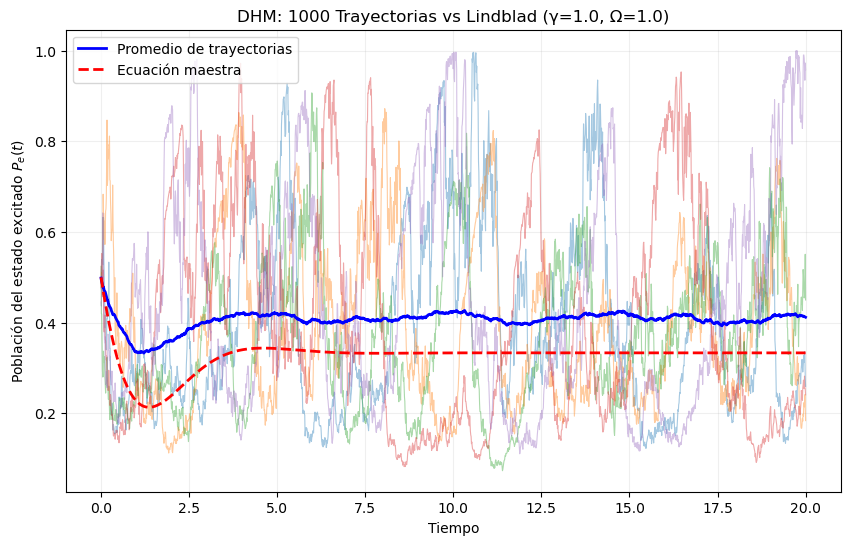

In [6]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

# Parámetros
gamma = 1.0       # Tasa de detección
phi = 0.0         # Fase del oscilador local
t_max = 20        # Tiempo máximo de simulación (reducido para claridad)
dt = 0.01
Omega = 1.0       # Frecuencia de Rabi
steps = int(t_max / dt)
Delta = 0.0       # Desintonía
num_traj = 1000     # Número de trayectorias (aumentar para mejor promedio)

# Operadores
sm = qt.destroy(2)  # σ-
sp = sm.dag()       # σ+
sigma_phi = (sp * np.exp(1j * phi) + sm * np.exp(-1j * phi)) / 2  # Operador de cuadratura
Pe = sp * sm        # Proyector |e⟩⟨e|

# Hamiltoniano del sistema (Rabi)
H_sys = 0.5 * Delta * qt.sigmaz() + 0.5 * Omega * (qt.sigmax())

# Función para evolucionar una trayectoria
def simulate_single_trajectory():
    dW = np.sqrt(dt) * np.random.randn(steps)  # Ruido aleatorio
    psi_t = (qt.basis(2, 0) + qt.basis(2, 1)).unit()  # Estado inicial
    pop_exc = []
    
    for i in range(steps):
        # Valor esperado de σ_ϕ
        sigma_phi_expect = qt.expect(sigma_phi, psi_t)
        eta_W = dW[i] / dt  # Ruido blanco
        
        # Hamiltoniano efectivo H_W (con retroalimentación)
        H_feedback = 1j * (2 * np.sqrt(gamma) * sigma_phi_expect + eta_W) * np.exp(-1j * phi) * np.sqrt(gamma) * sm
        H_total = H_sys + H_feedback
        
        # Evolución del estado
        dpsi = (-1j * H_total * psi_t) * dt
        psi_t = (psi_t + dpsi).unit()
        pop_exc.append(qt.expect(Pe, psi_t))  # Población de |e⟩
    
    return pop_exc

# Simulación de múltiples trayectorias
trajectories = np.zeros((num_traj, steps))
for k in range(num_traj):
    trajectories[k, :] = simulate_single_trajectory()
    print(f"Trayectoria {k+1}/{num_traj} completada", end="\r")

# Promedio de las trayectorias
average_pop = np.mean(trajectories, axis=0)

# Comparación con la ecuación maestra (Lindblad)
c_ops = [np.sqrt(gamma) * sm]  # Operador de colapso
rho0 = qt.ket2dm((qt.basis(2, 0) + qt.basis(2, 1)).unit())  # Estado inicial como matriz densidad
times = np.linspace(0, t_max, steps)
result = qt.mesolve(H_sys, rho0, times, c_ops, [Pe])
lindblad_pop = result.expect[0]

# Gráficos
plt.figure(figsize=(10, 6))

# Trayectorias individuales (solo graficamos algunas para claridad)
for k in range(min(5, num_traj)):  # Graficar 5 trayectorias
    plt.plot(times, trajectories[k, :], alpha=0.4, linewidth=0.8)

# Promedio vs Lindblad
plt.plot(times, average_pop, 'b-', linewidth=2, label="Promedio de trayectorias")
plt.plot(times, lindblad_pop, 'r--', linewidth=2, label="Ecuación maestra")

plt.xlabel("Tiempo")
plt.ylabel("Población del estado excitado $P_e(t)$")
plt.title(f"DHM: {num_traj} Trayectorias vs Lindblad (γ={gamma}, Ω={Omega})")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

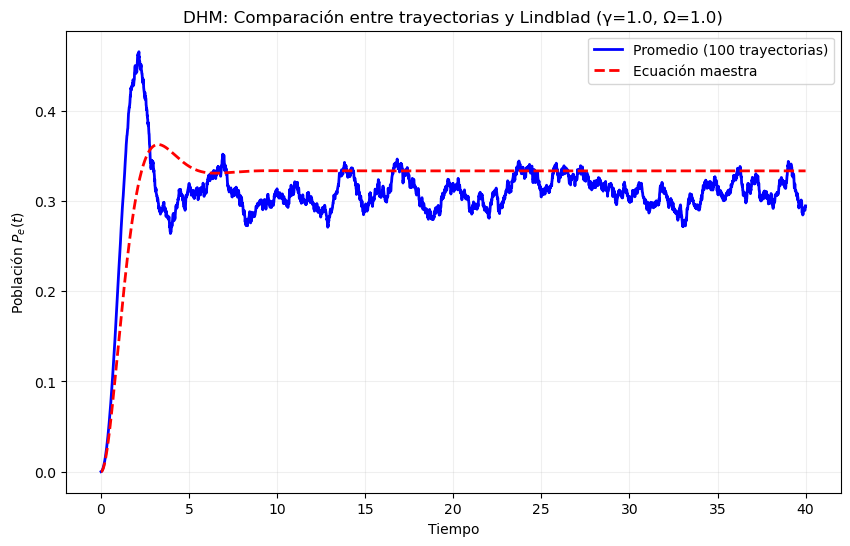

In [24]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

# Parámetros
gamma = 1.0          # Tasa de detección
phi = 0.0            # Fase del oscilador local (homodina)
t_max = 40          # Tiempo de simulación
dt = 0.01           # Paso de tiempo (reducido para precisión)
Omega = 1          # Frecuencia de Rabi
steps = int(t_max / dt)
Delta = 0.0          # Desintonía
num_traj = 100     # Número de trayectorias

# Operadores cuánticos
sm = qt.destroy(2)   # σ-
sp = sm.dag()        # σ+
sigma_x = qt.sigmax()# Operador σ_x (para ϕ=0, σ_ϕ = σ_x)
Pe = sp * sm         # Proyector |e⟩⟨e|

# Hamiltoniano del sistema (Rabi)
H_sys = 0.5 * Delta * qt.sigmaz() + 0.5 * Omega * sigma_x

# Función para una trayectoria estocástica
def simulate_trajectory():
    dW = np.sqrt(dt) * np.random.randn(steps)  # Ruido de Wiener
    psi_t = (qt.basis(2, 0) ).unit()  # Estado inicial |g⟩ + |e⟩
    pop_exc = []
    
    for i in range(steps):
        # Valor esperado de σ_x (para ϕ=0)
        sigma_x_expect = qt.expect(sigma_x, psi_t)
        
        # Término de retroalimentación (η_W = dW/dt)
        H_feedback = 1j * (2 * np.sqrt(gamma) * sigma_x_expect + dW[i] / dt) * np.sqrt(gamma) * sm
        H_total = H_sys + H_feedback
        
        # Evolución del estado
        dpsi = (-1j * H_total * psi_t) * dt
        psi_t = (psi_t + dpsi).unit()
        pop_exc.append(qt.expect(Pe, psi_t))
    
    return pop_exc

# Simulación de múltiples trayectorias
trajectories = np.zeros((num_traj, steps))
for k in range(num_traj):
    trajectories[k, :] = simulate_trajectory()
    print(f"Progreso: {k+1}/{num_traj}", end="\r")

# Promedio de trayectorias
average_pop = np.mean(trajectories, axis=0)

# Ecuación maestra (Lindblad)
c_ops = [np.sqrt(gamma) * sm]  # Operador de colapso
rho0 = qt.ket2dm((qt.basis(2, 0) ).unit())  # Estado inicial
times = np.linspace(0, t_max, steps)
result = qt.mesolve(H_sys, rho0, times, c_ops, [Pe])
lindblad_pop = result.expect[0]

# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(times, average_pop, 'b-', label=f"Promedio ({num_traj} trayectorias)", linewidth=2)
plt.plot(times, lindblad_pop, 'r--', label="Ecuación maestra", linewidth=2)
plt.xlabel("Tiempo")
plt.ylabel("Población $P_e(t)$")
plt.title("DHM: Comparación entre trayectorias y Lindblad (γ=1.0, Ω=1.0)")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

In [43]:
from qutip import basis, smesolve
import numpy as np
import matplotlib.pyplot as plt

# Definimos los estados base y excitado
NF = 2
Kg = basis(NF, 1)  # estado base
Ke = basis(NF, 0)  # estado excitado

# Estado inicial en |g>
psi0 = Kg

# Operadores de proyección
Agg = Kg * Kg.dag()
Aee = Ke * Ke.dag()
Aeg = Ke * Kg.dag()
Age = Kg * Ke.dag()

# Valores esperados (opciones de seguimiento del sistema)
expect_values = [Aee, Agg]  # Probabilidades de |e> y |g>

# Parámetros del sistema
Omega = 1  # Frecuencia de Rabi
g = 1  # Tasa de emisión espontánea

# Operador de colapso: emisión de |e> a |g>
Ceg = np.sqrt(g) * Age
collapse = [Ceg]
phi=np.pi/2
sigma_phi = (sp * np.exp(1j * phi) + sm * np.exp(-1j * phi)) / 2
collapse =[sigma_phi]
# Hamiltoniano: interacción entre |e> y |g>
H = 0.5 * Omega * (Aeg + Age)

# Tiempo de simulación
tlist = np.linspace(0, 40, 100)

# Opciones para smesolve
options = {"store_measurement": True, "map": "parallel"}

# Simulación con detección heterodina
result = smesolve(
    H,
    psi0,
    tlist,
    sc_ops=collapse,  # Operadores estocásticos
    heterodyne=False,  # Activar detección heterodina
    e_ops=expect_values,  # Valores esperados
    ntraj=2,  # Número de trayectorias
    options=options,
)



50.0%. Run time:   2.20s. Est. time left: 00:00:00:02
100.0%. Run time:   2.21s. Est. time left: 00:00:00:00
Total run time:   2.38s


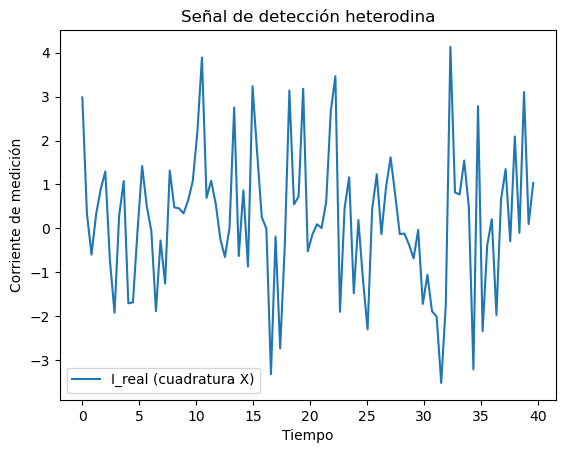

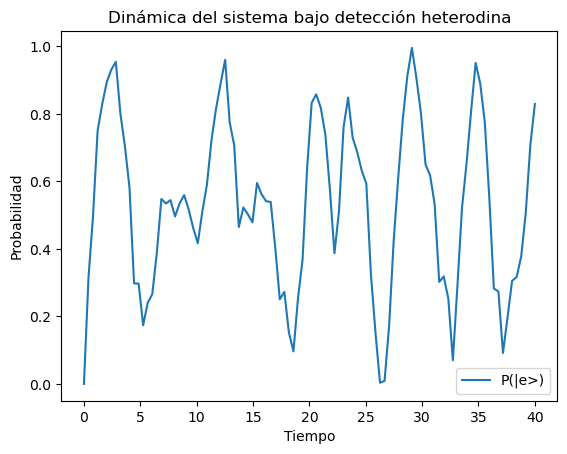

In [44]:
# Reestructuramos las mediciones
measurements = np.squeeze(result.measurement)  # Reducimos dimensiones
I_real = measurements  # Cuadratura real
I_real = np.mean(I_real, axis=0)

# Graficamos las corrientes medidas
plt.figure()
plt.plot(tlist[:-1], I_real, label="I_real (cuadratura X)")
#plt.plot(tlist[:-1], I_imag, label="I_imag (cuadratura Y)")
plt.xlabel("Tiempo")
plt.ylabel("Corriente de medición")
plt.legend()
plt.title("Señal de detección heterodina")
plt.show()

# Extraemos las probabilidades de estado
P_e = result.expect[0]
P_g = result.expect[1]

# Graficamos las probabilidades
plt.figure()
plt.plot(tlist, P_e, label="P(|e>)")
plt.xlabel("Tiempo")
plt.ylabel("Probabilidad")
plt.legend()
plt.title("Dinámica del sistema bajo detección heterodina")
plt.show()


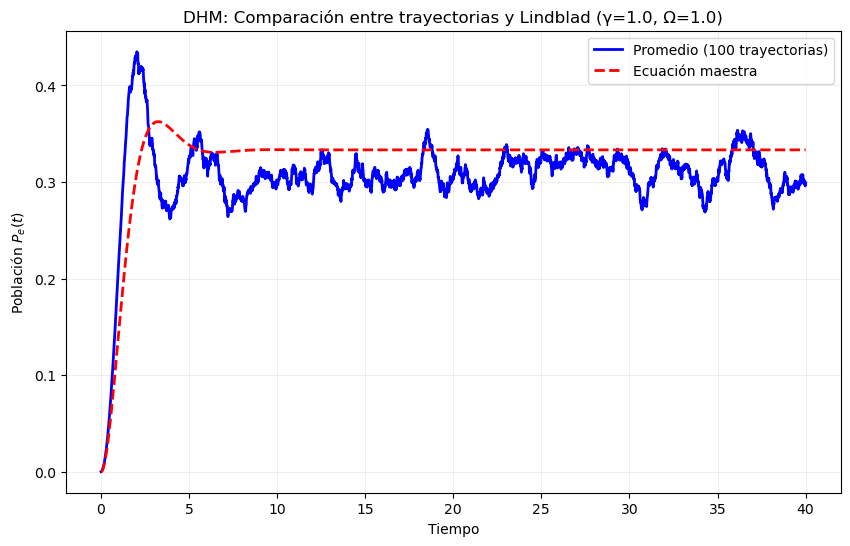

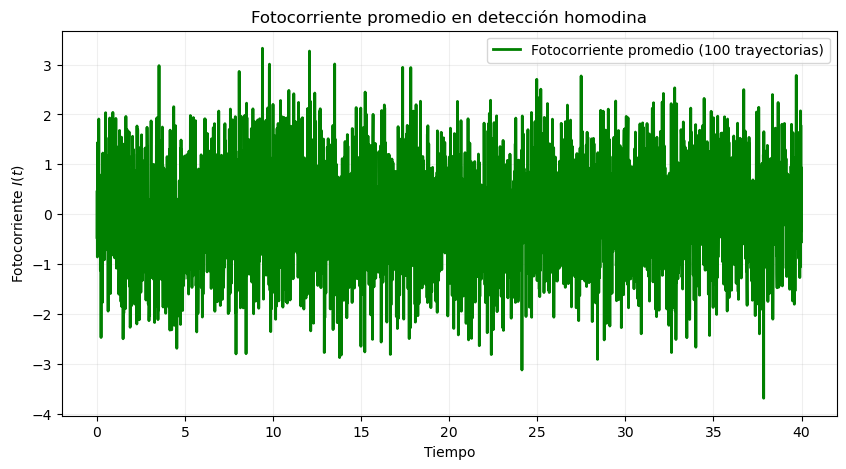

In [47]:
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

# Parámetros
gamma = 1.0          # Tasa de detección
phi = 0.0            # Fase del oscilador local (homodina)
t_max = 40          # Tiempo de simulación
dt = 0.01           # Paso de tiempo (reducido para precisión)
Omega = 1          # Frecuencia de Rabi
steps = int(t_max / dt)
Delta = 0.0          # Desintonía
num_traj = 100     # Número de trayectorias

# Operadores cuánticos
sm = qt.destroy(2)   # σ-
sp = sm.dag()        # σ+
sigma_x = qt.sigmax()# Operador σ_x (para ϕ=0, σ_ϕ = σ_x)
Pe = sp * sm         # Proyector |e⟩⟨e|

# Hamiltoniano del sistema (Rabi)
H_sys = 0.5 * Delta * qt.sigmaz() + 0.5 * Omega * sigma_x

# Inicialización de matrices para almacenar datos
trajectories = np.zeros((num_traj, steps))  # Población
photocurrents = np.zeros((num_traj, steps))  # Fotocorriente

# Función para una trayectoria estocástica
def simulate_trajectory():
    dW = np.sqrt(dt) * np.random.randn(steps)  # Ruido de Wiener
    psi_t = qt.basis(2, 0)  # Estado inicial |g>
    
    pop_exc = []
    I_t = []
    
    for i in range(steps):
        # Valor esperado de σ_x
        sigma_x_expect = qt.expect(sigma_x, psi_t)
        
        # Término de retroalimentación
        H_feedback = 1j * (2 * np.sqrt(gamma) * sigma_x_expect + dW[i] / dt) * np.sqrt(gamma) * sm
        H_total = H_sys + H_feedback
        
        # Evolución del estado
        dpsi = (-1j * H_total * psi_t) * dt
        psi_t = (psi_t + dpsi).unit()
        
        # Guardar valores
        pop_exc.append(qt.expect(Pe, psi_t))
        I_t.append(2 * np.sqrt(gamma) * sigma_x_expect + dW[i] / dt)  # Fotocorriente

    return pop_exc, I_t

# Simulación de múltiples trayectorias
for k in range(num_traj):
    pop_exc, I_t = simulate_trajectory()
    trajectories[k, :] = pop_exc
    photocurrents[k, :] = I_t
    print(f"Progreso: {k+1}/{num_traj}", end="\r")

# Promedio de trayectorias
average_pop = np.mean(trajectories, axis=0)
average_I = np.mean(photocurrents, axis=0)

# Ecuación maestra (Lindblad)
c_ops = [np.sqrt(gamma) * sm]  # Operador de colapso
rho0 = qt.ket2dm(qt.basis(2, 0))  # Estado inicial
times = np.linspace(0, t_max, steps)
result = qt.mesolve(H_sys, rho0, times, c_ops, [Pe])
lindblad_pop = result.expect[0]

# Gráfico de población
plt.figure(figsize=(10, 6))
plt.plot(times, average_pop, 'b-', label=f"Promedio ({num_traj} trayectorias)", linewidth=2)
plt.plot(times, lindblad_pop, 'r--', label="Ecuación maestra", linewidth=2)
plt.xlabel("Tiempo")
plt.ylabel("Población $P_e(t)$")
plt.title("DHM: Comparación entre trayectorias y Lindblad (γ=1.0, Ω=1.0)")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

# Gráfico de fotocorriente promedio
plt.figure(figsize=(10, 5))
plt.plot(times, average_I, 'g-', label=f"Fotocorriente promedio ({num_traj} trayectorias)", linewidth=2)
plt.xlabel("Tiempo")
plt.ylabel("Fotocorriente $I(t)$")
plt.title("Fotocorriente promedio en detección homodina")
plt.legend()
plt.grid(alpha=0.2)
plt.show()


In [52]:
qt.sigmax().dag()*qt.sigmax()

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[1. 0.]
 [0. 1.]]

In [50]:
qt.sigmaz()

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]

In [ ]:
(delta - j*g*0.5)*qt.sigmax()*qtsigmax()